In [1]:
#Load packages 
import sqlite3 
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
sns.set_style('whitegrid')
import csv

In [2]:
#Take a look at the TMDB provided dataset
tmdb_movies = pd.read_csv('/Users/arun/Desktop/Flatiron/Project1/dsc-phase-1-project-template/zippedData/tmdb.movies.csv', encoding = 'unicode_escape')
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [3]:
#getting information on the dataset. No NA values, looks great. Have to find names for genre_ids
tmdb_movies.info()
tmdb_movies.describe()
tmdb_movies.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [4]:
#dropping unnecessary columns
tmdb_movies.drop(['Unnamed: 0','title','original_language','id'], axis = 1, inplace = True)

#rename the orginal_title column to movie. will help with merging with other dataframes later.
tmdb_movies.rename(columns={"original_title": "movie"}, inplace = True)

#converting release year column to a datetime format
tmdb_movies["release_year"] = pd.to_datetime(tmdb_movies["release_date"], format="%Y/%m/%d")

#drop release_date
tmdb_movies.drop(['release_date'], axis = 1, inplace = True)
tmdb_movies.head()

,genre_ids,movie,popularity,vote_average,vote_count,release_year
0,"[12, 14, 10751]",Harry Potter and the Deathly Hallows: Part 1,33.533,7.7,10788,2010-11-19
1,"[14, 12, 16, 10751]",How to Train Your Dragon,28.734,7.7,7610,2010-03-26
2,"[12, 28, 878]",Iron Man 2,28.515,6.8,12368,2010-05-07
3,"[16, 35, 10751]",Toy Story,28.005,7.9,10174,1995-11-22
4,"[28, 878, 12]",Inception,27.920,8.3,22186,2010-07-16


In [5]:
#strip the genre_ids columns of brackets and quotes
tmdb_movies['genre_ids'] = tmdb_movies['genre_ids'].apply(lambda x: x.replace('[','').replace(']','').split(','))

#each movie has a list of genres. we want the genres to be sepereate so we can count them
tmdb_movies = tmdb_movies.explode('genre_ids')
tmdb_movies.head()

,genre_ids,movie,popularity,vote_average,vote_count,release_year
0,12,Harry Potter and the Deathly Hallows: Part 1,33.533,7.7,10788,2010-11-19
0,14,Harry Potter and the Deathly Hallows: Part 1,33.533,7.7,10788,2010-11-19
0,10751,Harry Potter and the Deathly Hallows: Part 1,33.533,7.7,10788,2010-11-19
1,14,How to Train Your Dragon,28.734,7.7,7610,2010-03-26
1,12,How to Train Your Dragon,28.734,7.7,7610,2010-03-26


In [6]:
# Replace empty strings or spaces with np.nan
tmdb_movies.genre_ids = tmdb_movies.genre_ids.replace(r'^\s*$', np.nan, regex=True)

# Convert entries to floats
tmdb_movies['genre_ids'] = tmdb_movies['genre_ids'].apply(lambda x: float(x))

#look at current structure
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47834 entries, 0 to 26516
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   genre_ids     45355 non-null  float64       
 1   movie         47834 non-null  object        
 2   popularity    47834 non-null  float64       
 3   vote_average  47834 non-null  float64       
 4   vote_count    47834 non-null  int64         
 5   release_year  47834 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 2.6+ MB


In [7]:
#found movie genres that corespond to genres in tmdb_movies table  
movie_genres = [{"id": 28,"name": "Action"},
    {"id": 12,"name": "Adventure"},
    {"id": 16,"name": "Animation"},
    {"id": 35,"name": "Comedy"},
    {"id": 80,"name": "Crime"},
    {"id": 99,"name": "Documentary"},
    {"id": 18,"name": "Drama"},
    {"id": 10751,"name": "Family"},
    {"id": 14,"name": "Fantasy"},
    {"id": 36,"name": "History"},
    {"id": 27,"name": "Horror"},
    {"id": 10402,"name": "Music"},
    {"id": 9648,"name": "Mystery"},
    {"id": 10749,"name": "Romance"},
    {"id": 878,"name": "Science Fiction"},
    {"id": 10770,"name": "TV Movie"},
    {"id": 53,"name": "Thriller"},
    {"id": 10752,"name": "War"},
    {"id": 37,"name": "Western"}]

In [8]:
# Define a function that returns 'None' if key is np.nan, otherwise, find id in dictionary and return value
def find_genre(key):
    if key is np.nan:
        return 'None'
    for dictionary in movie_genres:
        if dictionary['id'] == float(key):
            return dictionary['name']
    return 'None'

# Apply find_genre function to genre_ids
tmdb_movies['genre_ids'] = tmdb_movies['genre_ids'].apply(lambda x: find_genre(x))
tmdb_movies.head()

,genre_ids,movie,popularity,vote_average,vote_count,release_year
0,Adventure,Harry Potter and the Deathly Hallows: Part 1,33.533,7.7,10788,2010-11-19
0,Fantasy,Harry Potter and the Deathly Hallows: Part 1,33.533,7.7,10788,2010-11-19
0,Family,Harry Potter and the Deathly Hallows: Part 1,33.533,7.7,10788,2010-11-19
1,Fantasy,How to Train Your Dragon,28.734,7.7,7610,2010-03-26
1,Adventure,How to Train Your Dragon,28.734,7.7,7610,2010-03-26


In [9]:
#There are movies in the dataset which don't belong to any category. Removing them from the dataset
tmdb_movies['genre_ids'].unique()
tmdb_movies = tmdb_movies[tmdb_movies['genre_ids'] != 'None']

In [10]:
#get budget data for the movies
tn_movie_budgets = pd.read_csv('/Users/arun/Desktop/Flatiron/Project1/dsc-phase-1-project-template/zippedData/tn.movie_budgets.csv')
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [11]:
#No null values, but only 5782 data points
tn_movie_budgets.info()
tn_movie_budgets.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [12]:
#remove dollar signs and commas from columns and change the type to integers
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].replace('[\$,]', '', regex=True).astype(int)
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].replace('[\$,]', '',regex=True).astype(int)
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].replace('[\$,]','', regex= True).astype(int)

In [13]:
#subtracting worldwide gross from budget to get the total profit 
tn_movie_budgets['profit'] = tn_movie_budgets.apply(lambda x: x['worldwide_gross'] - x['production_budget'], axis=1)

#drop release_date and id from dataframe 
tn_movie_budgets.drop(['release_date', 'id'], axis = 1, inplace = True)
tn_movie_budgets.head()

,movie,production_budget,domestic_gross,worldwide_gross,profit
0,Avatar,425000000,760507625,2776345279,2351345279
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
2,Dark Phoenix,350000000,42762350,149762350,-200237650
3,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
4,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747


In [14]:
#merge tmdb_movies with tn_budget. common value will be the movie name.
tmdb_movie_budgets = pd.merge(tmdb_movies, tn_movie_budgets, on='movie', how='left')
tmdb_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45532 entries, 0 to 45531
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          45532 non-null  object        
 1   movie              45532 non-null  object        
 2   popularity         45532 non-null  float64       
 3   vote_average       45532 non-null  float64       
 4   vote_count         45532 non-null  int64         
 5   release_year       45532 non-null  datetime64[ns]
 6   production_budget  5472 non-null   float64       
 7   domestic_gross     5472 non-null   float64       
 8   worldwide_gross    5472 non-null   float64       
 9   profit             5472 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 3.8+ MB


In [15]:
#drop all the null values, this will drastically reduce the dataset. 
tmdb_movie_budgets = tmdb_movie_budgets.dropna()
tmdb_movie_budgets.info()
tmdb_movie_budgets.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5472 entries, 3 to 45516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          5472 non-null   object        
 1   movie              5472 non-null   object        
 2   popularity         5472 non-null   float64       
 3   vote_average       5472 non-null   float64       
 4   vote_count         5472 non-null   int64         
 5   release_year       5472 non-null   datetime64[ns]
 6   production_budget  5472 non-null   float64       
 7   domestic_gross     5472 non-null   float64       
 8   worldwide_gross    5472 non-null   float64       
 9   profit             5472 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 470.2+ KB


,genre_ids,movie,popularity,vote_average,vote_count,release_year,production_budget,domestic_gross,worldwide_gross,profit
3,Fantasy,How to Train Your Dragon,28.734,7.7,7610,2010-03-26,165000000.0,217581232.0,494870992.0,329870992.0
4,Adventure,How to Train Your Dragon,28.734,7.7,7610,2010-03-26,165000000.0,217581232.0,494870992.0,329870992.0
5,Animation,How to Train Your Dragon,28.734,7.7,7610,2010-03-26,165000000.0,217581232.0,494870992.0,329870992.0
6,Family,How to Train Your Dragon,28.734,7.7,7610,2010-03-26,165000000.0,217581232.0,494870992.0,329870992.0
7,Adventure,Iron Man 2,28.515,6.8,12368,2010-05-07,170000000.0,312433331.0,621156389.0,451156389.0
8,Action,Iron Man 2,28.515,6.8,12368,2010-05-07,170000000.0,312433331.0,621156389.0,451156389.0
9,Science Fiction,Iron Man 2,28.515,6.8,12368,2010-05-07,170000000.0,312433331.0,621156389.0,451156389.0
10,Animation,Toy Story,28.005,7.9,10174,1995-11-22,30000000.0,191796233.0,364545516.0,334545516.0
11,Comedy,Toy Story,28.005,7.9,10174,1995-11-22,30000000.0,191796233.0,364545516.0,334545516.0
12,Family,Toy Story,28.005,7.9,10174,1995-11-22,30000000.0,191796233.0,364545516.0,334545516.0


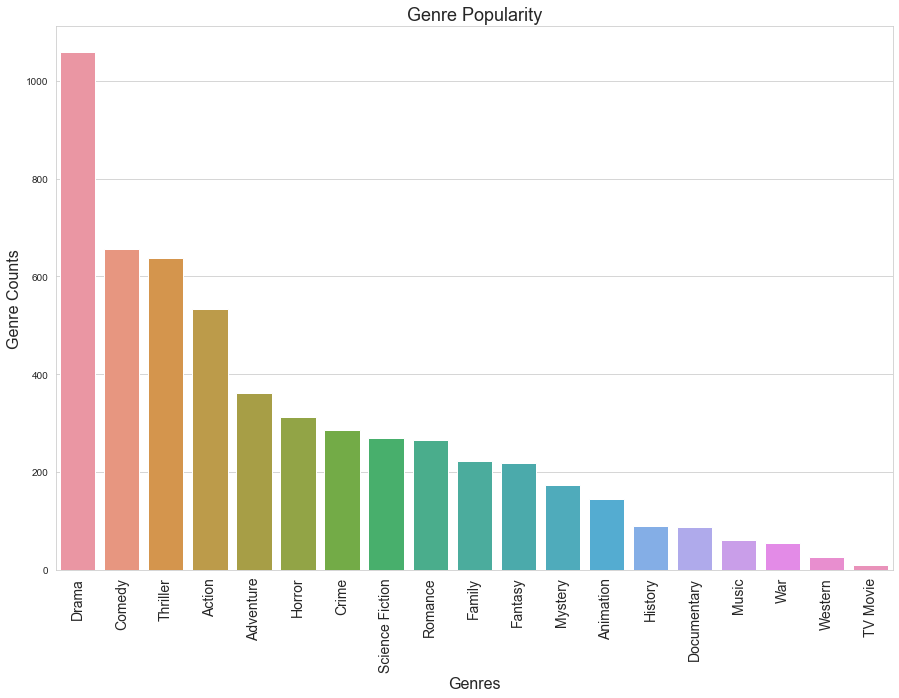

In [16]:
#Plot the distribution of Genre, from most to least popular.
plt.figure(figsize=(15, 10))
sns.countplot(x="genre_ids", data=tmdb_movie_budgets, order = tmdb_movie_budgets['genre_ids'].value_counts().index);
plt.xlabel("Genres", fontsize=16)
plt.ylabel("Genre Counts", fontsize=16)
plt.title("Genre Popularity", fontsize=18) 
plt.xticks(rotation=90, fontsize = 14)
plt.show();

In [17]:
#Calculate Percentage ROI = (Net income / Cost of investment) x 100. 
tmdb_movie_budgets['roi'] = (tmdb_movie_budgets['profit'] / tmdb_movie_budgets['production_budget']) * 100
tmdb_movie_budgets.head()

,genre_ids,movie,popularity,vote_average,vote_count,release_year,production_budget,domestic_gross,worldwide_gross,profit,roi
3,Fantasy,How to Train Your Dragon,28.734,7.7,7610,2010-03-26,165000000.0,217581232.0,494870992.0,329870992.0,199.921813
4,Adventure,How to Train Your Dragon,28.734,7.7,7610,2010-03-26,165000000.0,217581232.0,494870992.0,329870992.0,199.921813
5,Animation,How to Train Your Dragon,28.734,7.7,7610,2010-03-26,165000000.0,217581232.0,494870992.0,329870992.0,199.921813
6,Family,How to Train Your Dragon,28.734,7.7,7610,2010-03-26,165000000.0,217581232.0,494870992.0,329870992.0,199.921813
7,Adventure,Iron Man 2,28.515,6.8,12368,2010-05-07,170000000.0,312433331.0,621156389.0,451156389.0,265.386111


In [18]:
#Group the data by mean ROI of genres
group_genre_roi = tmdb_movie_budgets.groupby(['genre_ids'])['roi'].mean().reset_index()
group_genre_roi = group_genre_roi.sort_values(by='roi', ascending=False)
group_genre_roi 

,genre_ids,roi
10,Horror,843.923645
7,Family,406.647819
2,Animation,402.587455
16,Thriller,369.711095
12,Mystery,347.938223
8,Fantasy,343.723922
13,Romance,323.521585
14,Science Fiction,283.689524
6,Drama,250.868772
3,Comedy,241.317309


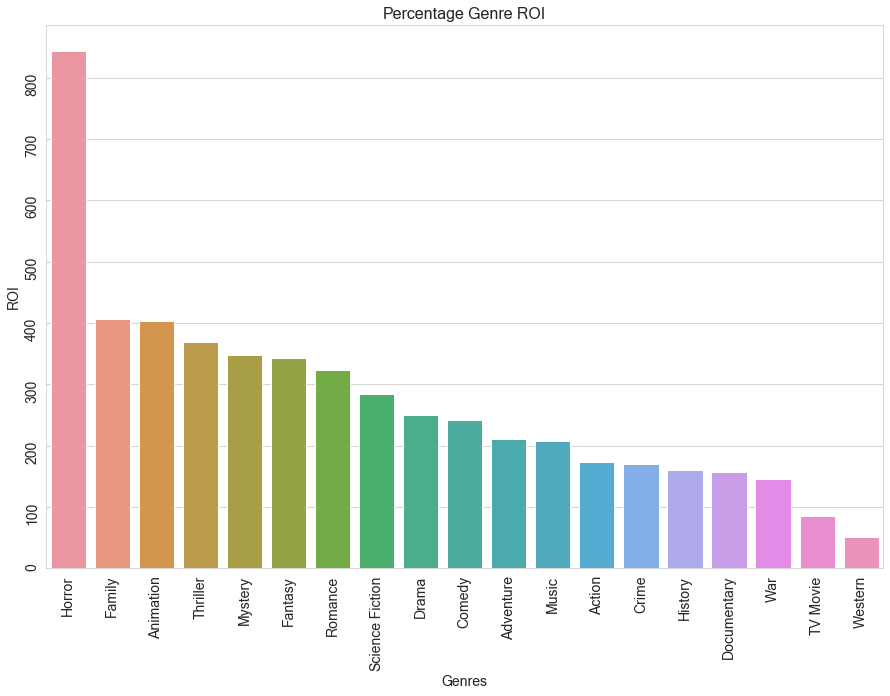

In [19]:
#Plot the Genre by ROI Percentage
plt.figure(figsize=(15, 10))
sns.barplot(data=group_genre_roi, x="genre_ids", y="roi")

plt.xlabel("Genres", fontsize = 14, fontname="Microsoft Sans Serif")
plt.ylabel("ROI", fontsize = 14, fontname="Microsoft Sans Serif")
plt.title("Percentage Genre ROI", fontsize = 16, fontname="Microsoft Sans Serif")
plt.xticks(rotation=90, fontsize = 14, fontname="Microsoft Sans Serif")
plt.yticks(rotation=90, fontsize = 14, fontname="Microsoft Sans Serif")
plt.show();

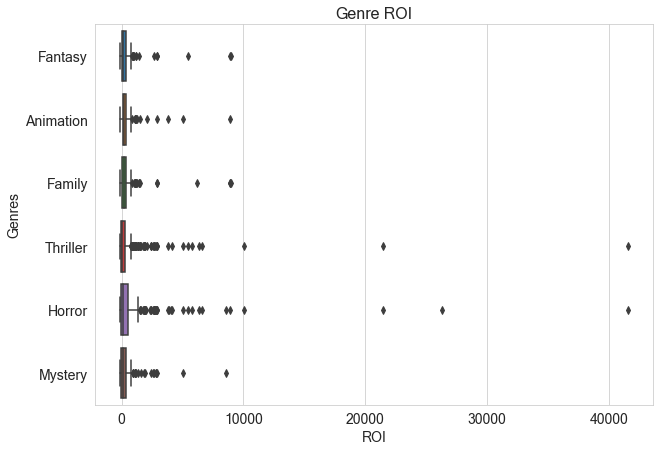

In [20]:
#This shows us the outliers. What would the categories look like if we took the outlies out.
plt.figure(figsize=(10, 7))
pop_genres = ['Horror', 'Family', 'Animation', 'Thriller', 'Mystery', 'Fantasy']
boxplot_df = tmdb_movie_budgets.loc[tmdb_movie_budgets['genre_ids'].isin(pop_genres)]

sns.boxplot(x =boxplot_df['roi'], y= boxplot_df['genre_ids'])
plt.xlabel("ROI", fontsize = 14, fontname="Microsoft Sans Serif")
plt.xticks(fontsize = 14, fontname="Microsoft Sans Serif")
plt.ylabel("Genres", fontsize = 14, fontname="Microsoft Sans Serif")
plt.yticks(fontsize = 14, fontname="Microsoft Sans Serif")
plt.title("Genre ROI", fontsize = 16, fontname="Microsoft Sans Serif")
plt.show();

In [23]:
#drop roi higher then 1500 from the original dataset
outliers= tmdb_movie_budgets.drop(tmdb_movie_budgets[tmdb_movie_budgets['roi'] > 3500].index,inplace=True)
outliers = tmdb_movie_budgets.sort_values(by=['roi'], ascending = False)
outliers['roi'].max()

1490.000705

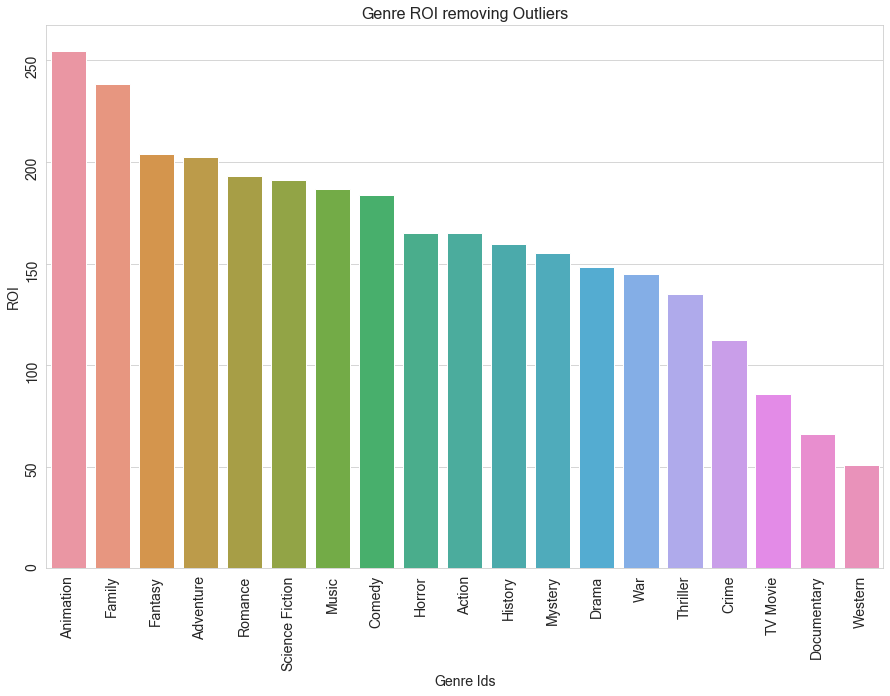

In [24]:
plt.figure(figsize=(15, 10))
genre_bar_df = outliers.groupby('genre_ids')['roi'].mean().sort_values(ascending = False).to_frame().reset_index()
sns.barplot(data = genre_bar_df, x='genre_ids', y='roi')

plt.xlabel("Genre Ids", fontsize = 14, fontname="Microsoft Sans Serif")
plt.xticks(rotation=90, fontsize = 14, fontname="Microsoft Sans Serif")
plt.ylabel("ROI", fontsize = 14, fontname="Microsoft Sans Serif")
plt.yticks(rotation=90, fontsize = 14, fontname="Microsoft Sans Serif")
plt.title("Genre ROI removing Outliers", fontsize = 16, fontname="Microsoft Sans Serif")
plt.show();

In [25]:
#Group the data by mean ROI of genres
group_genre_roi_outliers = outliers.groupby(['genre_ids'])['roi'].mean().reset_index()
group_genre_roi_outliers.sort_values(by ='roi', ascending = False)
group_genre_roi_outliers

,genre_ids,roi
0,Action,164.992436
1,Adventure,202.316279
2,Animation,254.746053
3,Comedy,183.823793
4,Crime,112.374556
5,Documentary,66.057027
6,Drama,148.561020
7,Family,238.300769
8,Fantasy,203.728435
9,History,159.874826


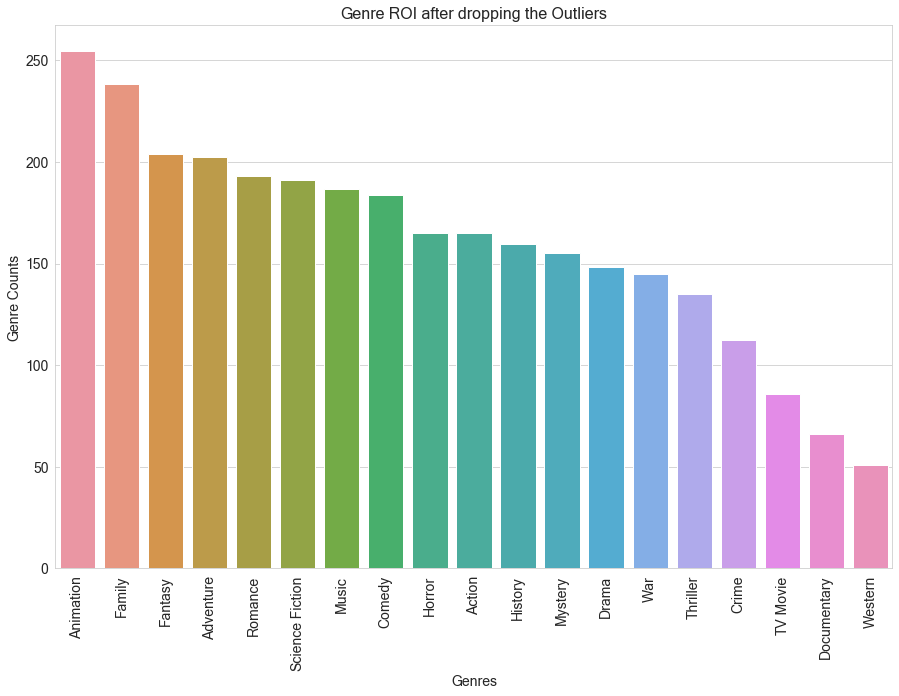

In [51]:
#Removing the outliers changed what genres are the most profitable 
plt.figure(figsize=(15, 10))
sns.barplot(data=group_genre_roi_outliers.sort_values(by ='roi', ascending = False), x="genre_ids", y="roi")

plt.xlabel("Genres", fontsize = 14, fontname="Microsoft Sans Serif")
plt.ylabel("Genre Counts", fontsize = 14, fontname="Microsoft Sans Serif")
plt.title("Genre ROI after dropping the Outliers", fontsize = 16, fontname="Microsoft Sans Serif") 
plt.xticks(fontsize = 14, fontname="Microsoft Sans Serif")
plt.yticks(fontsize = 14, fontname="Microsoft Sans Serif")
plt.xticks(rotation=90)
plt.show();

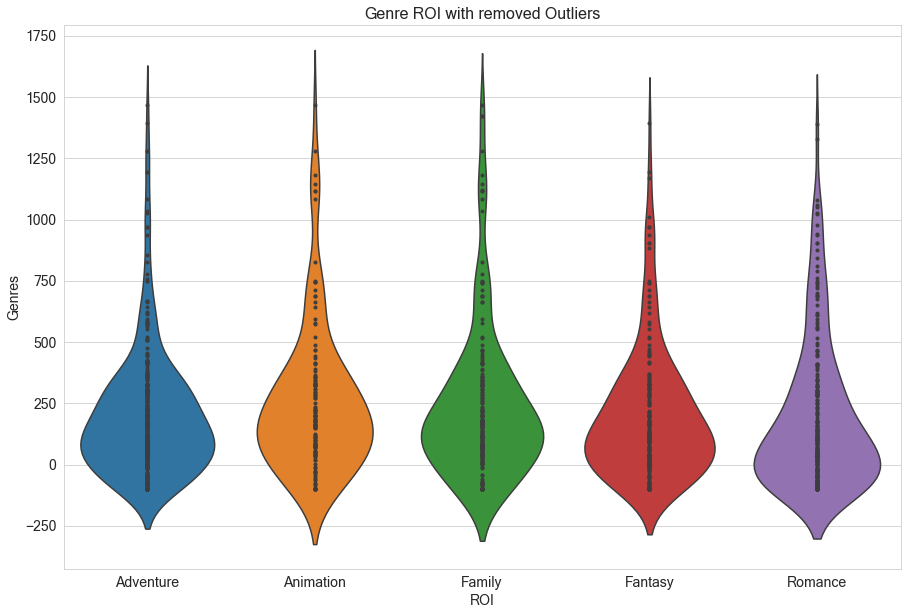

In [53]:
#Spread of ROI after removing the outliers. Perhaps Comedy has higher ROI because it doesn't require as many special effects. 
plt.figure(figsize=(15, 10))
pop_genres_outliers = ['Animation','Family','Fantasy','Adventure','Romance']
boxplot_df = outliers.loc[outliers['genre_ids'].isin(pop_genres_outliers)]

#defining plot visualizations 
sns.violinplot( data = boxplot_df, x='genre_ids', y= 'roi', inner='points')
plt.xlabel("ROI", fontsize = 14, fontname="Microsoft Sans Serif")
plt.ylabel("Genres", fontsize = 14, fontname="Microsoft Sans Serif")
plt.title("Genre ROI with removed Outliers", fontsize = 16, fontname="Microsoft Sans Serif") 
plt.xticks(fontsize = 14, fontname="Microsoft Sans Serif")
plt.yticks(fontsize = 14, fontname="Microsoft Sans Serif")
plt.show();